In [84]:
#importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import simpy
from simpy_helpers import Source, Resource , Stats, Entity
from datetime import datetime, timedelta
from matplotlib.animation import FuncAnimation
import random

## Port Process Overview

### Arrival at the Port:
- The ship arrives at the port, and the arrival time (`arrival_time`) is recorded.
- The real-world date and time (`real_arrival_time`) is derived from the simulation clock.
- The ship’s type and cargo are identified, and the current size of the berth queues is logged.

### Waiting for Daylight (Night Wait):
- If the ship arrives at night (before 8 AM or after 8 PM), it must wait until 8 AM.
- The wait time until daylight is calculated, and the ship waits for this period.

### Berth Request:
- The ship requests a berth and enters the queue if one is unavailable.
- The function checks meteorological conditions to determine if the ship can proceed.
  
### Meteorological Check (Every 3 Hours):
- Every 3 hours, the meteorological conditions are checked to ensure it's safe for the ship to dock and load.
  
### Waiting Time Calculations:
- Night waiting time (`night_waiting_time`), meteorological check waiting time (`mc_waiting_time`), and berth waiting time (`berth_waiting_time`) are calculated and logged.

### Loading Process:
- **Pre-Service**: Before loading, the ship undergoes a random pre-service wait (`pre_service_time`).
- **Loading**: The ship starts loading once conditions are met. The loading rate is affected by maintenance if it falls within a maintenance period (2/3 of the normal rate).
  - The function simulates loading in time steps (`time_step`), adjusting for weather and storage availability.
  - If forced to depart due to weather, the ship leaves, and a forced departure is logged.
  - If storage is insufficient, the ship waits for a storage refill.
- **Post-Service**: After loading, the ship undergoes a random post-service wait (`post_service_time`).

### Forced Departure:
- If weather conditions deteriorate significantly (forced departure threshold is reached), the ship must leave and wait in the pilot boarding area.
- If the ship is a GPL carrier and sufficiently filled, it may depart without returning to port.

### Departure:
- After loading, the ship releases the berth and departs the port.
- The function logs the entire process, including loading time, waiting time, and total turnaround time (`TAT`), as well as the cargo loaded.
- If a forced departure occurs, it is recorded.

### Maintenance Period:
- During certain periods of the year, one of the three loading arms at the berth undergoes maintenance for 7 random days.
- During maintenance, only two arms are available, and the loading rate is reduced to 2/3 of the normal rate.


In [3]:
def time_to_minutes(time_str):
    """Convert HH:MM time format to total minutes."""
    hours, minutes = map(int, time_str.split(':'))
    return hours * 60 + minutes

def minutes_to_time(minutes):
    """Convert total minutes to HH:MM time format."""
    hours = minutes // 60
    minutes = minutes % 60
    return f"{hours}:{minutes:02}"

def average_time(time_list):
    """Calculate the average time from a list of HH:MM time strings."""
    total_minutes = sum(time_to_minutes(time) for time in time_list)
    average_minutes = total_minutes / len(time_list)
    return minutes_to_time(int(average_minutes))
def max_time(time_list):
    """Calculate the maximum time from a list of HH:MM time strings."""
    max_minutes = max(time_to_minutes(time) for time in time_list)
    return minutes_to_time(int(max_minutes))

def format_time( sim_time):
    hours = int(sim_time)
    minutes = int((sim_time - int(sim_time)) * 60)
    return f"{hours}:{minutes:02}"

def time_date(year , month , day , hour , minute =0):
    current_time = datetime(year, month, day, hour)
    current_time = f"{current_time.year}-{current_time.month:02d}-{current_time.day:02d} {hour}:{minute:02d}"
    return current_time
def get_closest_time(current_time):
    """
    Get the closest time to the current time where the hour is a multiple of 3 and the minutes are zero.
    
    Parameters:
    current_time (datetime): The current time.
    
    Returns:
    datetime: The closest time with hour % 3 == 0 and minutes == 0.
    """
    current_hour = current_time.hour
    next_hour = (current_hour // 3 + 1) * 3 if current_hour % 3 != 0 else current_hour
    if next_hour == 24:
        next_hour = 0
        current_time += timedelta(days=1)
    closest_time = current_time.replace(hour=next_hour, minute=0, second=0, microsecond=0)
    return closest_time
def get_closest_time(current_time):
    """
    Get the closest time to the current time where the hour is a multiple of 3 and the minutes are zero.
    
    Parameters:
    current_time (datetime): The current time.
    
    Returns:
    datetime: The closest time with hour % 3 == 0 and minutes == 0.
    """
    current_hour = current_time.hour
    
    # Calculate the next closest time
    next_hour = (current_hour // 3 + 1) * 3 if current_hour % 3 != 0 else current_hour
    if next_hour == 24:
        next_hour = 0
        next_time = (current_time + timedelta(days=1)).replace(hour=next_hour, minute=0, second=0, microsecond=0)
    else:
        next_time = current_time.replace(hour=next_hour, minute=0, second=0, microsecond=0)
    
    # Calculate the previous closest time
    prev_hour = (current_hour // 3) * 3 if current_hour % 3 != 0 else current_hour - 3
    if prev_hour < 0:
        prev_hour = 21
        prev_time = (current_time - timedelta(days=1)).replace(hour=prev_hour, minute=0, second=0, microsecond=0)
    else:
        prev_time = current_time.replace(hour=prev_hour, minute=0, second=0, microsecond=0)
    
    # Determine which of the two times is closer to the current time
    if abs((current_time - prev_time).total_seconds()) <= abs((next_time - current_time).total_seconds()):
        return prev_time
    else:
        return next_time

In [4]:
Weather = pd.read_excel('Weather_Time_Series.xlsx')
Weather.head()

,Date,Wave direction [deg],Wave height [m],Wave period [s],Wind direction [deg],Wind speed [m/s]
0,2015-01-01 0:00,352,0.22,9.25,11,8.34
1,2015-01-01 3:00,8,0.20,9.32,4,7.51
2,2015-01-01 6:00,337,0.19,10.19,8,6.54
3,2015-01-01 9:00,292,0.19,11.05,8,6.68
4,2015-01-01 12:00,292,0.20,10.86,4,6.31


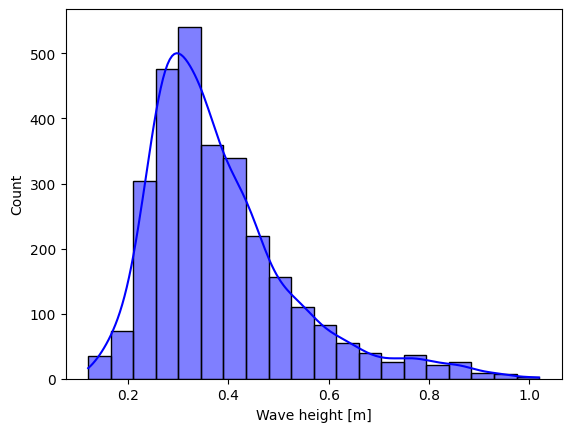

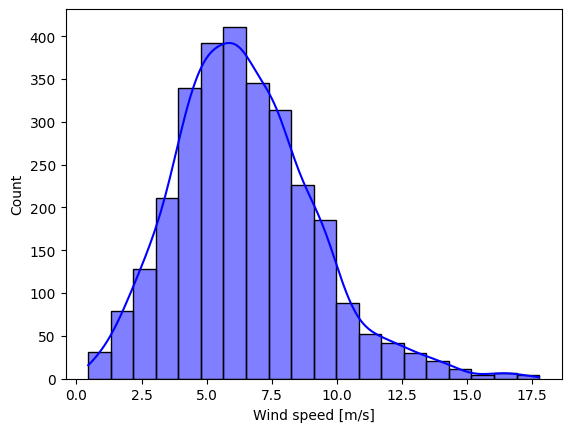

In [5]:

sns.histplot(data=Weather, x='Wave height [m]', color='blue', bins=20, kde=True)
plt.show()

sns.histplot(data=Weather, x='Wind speed [m/s]', color='blue', bins=20, kde=True)
plt.show()

In [6]:
print(Weather.keys())
Weather.describe()

Index(['Date', 'Wave direction [deg]', 'Wave height [m]', 'Wave period [s]',
       'Wind direction [deg]', 'Wind speed [m/s]'],
      dtype='object')


,Wave direction [deg],Wave height [m],Wave period [s],Wind direction [deg],Wind speed [m/s]
count,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000
mean,305.767808,0.382380,11.089812,129.297945,6.485103
std,96.090315,0.143847,2.820716,139.591086,2.670264
min,1.000000,0.120000,4.590000,0.000000,0.450000
25%,322.000000,0.280000,8.850000,16.000000,4.650000
50%,338.000000,0.350000,10.900000,48.000000,6.250000
75%,352.000000,0.440000,13.160000,307.000000,8.045000
max,359.000000,1.020000,20.730000,360.000000,17.780000


In [8]:
class ShipArrivalModel:
    def __init__(self, env, production_data):
        self.env = env
        
        self.production_data = production_data
        self.previous_eta = 0  # Initial ETA for the first ship

    def select_random_ship(self):
        """Randomly select a ship type based on fleet composition probabilities."""
        product = np.random.choice(self.production_data['Product_Type'], p=self.production_data['Composition'])

        if product == 'Liquide':
            fleet_composition = self.production_data[self.production_data['Product_Type'] == 'GPL'].loc[0, 'fleet_composition']
            ship_type = np.random.choice(fleet_composition['Ship_Type'], p=fleet_composition['Composition'])
            capacity = fleet_composition.loc[fleet_composition['Ship_Type'] == ship_type, 'Capacity'].values[0]
        else:
            fleet_composition = self.production_data[self.production_data['Product_Type'] == 'Gasoline'].loc[1, 'fleet_composition']
            ship_type = np.random.choice(fleet_composition['Ship_Type'], p=fleet_composition['Composition'])
            capacity = fleet_composition.loc[fleet_composition['Ship_Type'] == ship_type, 'Capacity'].values[0]
        

        return ship_type, capacity , product
    



    def calculate_iat(self, capacity , days = 366):
        """Calculate the Inter-Arrival Time (IAT) for the ship."""
        production_per_data = self.production_data['proction_per_year'].sum()/days
        iat = capacity / production_per_data
        return iat
    

import numpy as np

class ShipArrivalModel:
    def __init__(self, env, production_data):
        self.env = env
        self.production_data = production_data
        self.previous_eta = 0  # Initial ETA for the first ship

    def select_random_ship(self):
        """Randomly select a ship type based on fleet composition probabilities."""
        # Randomly select a product type based on its composition in production data
        product_type = np.random.choice(list(self.production_data.keys()), 
                                        p=[self.production_data[key]['Composition'] for key in self.production_data])

        # Get the fleet composition dictionary for the chosen product type
        fleet_composition = self.production_data[product_type]['Fleet Composition']
        
        # Randomly select a ship type within the chosen fleet composition based on its probability
        ship_types = list(fleet_composition.keys())
        probabilities = [fleet_composition[ship]['Composition'] for ship in ship_types]
        
        # Select a ship type based on probabilities
        ship_type = np.random.choice(ship_types, p=probabilities)
        
        # Access the capacity of the selected ship type
        capacity = fleet_composition[ship_type]['Capacity']
        
        return ship_type, capacity, product_type

    def calculate_iat(self, capacity, days=366):
        """Calculate the Inter-Arrival Time (IAT) for the ship."""
        # Calculate the total production per day
        production_per_day = sum(data['Production per Year'] for data in self.production_data.values()) / days
        
        # Calculate the Inter-Arrival Time (IAT) based on ship capacity and daily production
        iat = capacity / production_per_day
        return iat

    

    

In [9]:
import numpy as np

class ShipArrivalModel:
    def __init__(self, env, production_data ):
        """
        Initialize the ShipArrivalModel for a single product.
        
        Parameters:
        - env: SimPy environment.
        - production_data: Dictionary containing production details for a single product.
          Expected structure:
          {
              'Production per Year': <annual production>,
              'Fleet Composition': {
                  'Ship_Type_A': {'Capacity': <capacity>, 'Composition': <probability>},
                  'Ship_Type_B': {'Capacity': <capacity>, 'Composition': <probability>}
              }
          }
        """
        self.env = env
        self.production_data = production_data
        self.previous_eta = 0  # Initial ETA for the first ship
        

    def select_random_ship(self):
        """
        Randomly select a ship type based on fleet composition probabilities.
        
        Returns:
        - ship_type: Selected ship type.
        - capacity: Capacity of the selected ship type.
        """
        # Get the fleet composition dictionary
        product = list(self.production_data.keys())[0]
        fleet_composition = self.production_data[product]['Fleet Composition']
        
        # Randomly select a ship type based on probabilities
        ship_types = list(fleet_composition.keys())
        probabilities = [fleet_composition[ship]['Composition'] for ship in ship_types]
        
        # Select a ship type based on probabilities
        ship_type = np.random.choice(ship_types, p=probabilities)
        
        # Access the capacity of the selected ship type
        capacity = fleet_composition[ship_type]['Capacity']

        
        
        return ship_type, capacity , product

    def calculate_iat(self, capacity, days=366):
        """
        Calculate the Inter-Arrival Time (IAT) for the ship.
        
        Parameters:
        - capacity: Capacity of the selected ship.
        - days: Number of days in the simulation (default: 366).
        
        Returns:
        - iat: Inter-Arrival Time (in days).
        """
        # Calculate the daily production rate
        production_per_day = sum(data['Production per Year'] for data in self.production_data.values()) / days
        
        # Calculate the Inter-Arrival Time (IAT) based on ship capacity and daily production
        iat = capacity / production_per_day
        return iat


In [179]:
import numpy as np

class GenerateShips:
    def __init__(self, env, berths, berth_maintenance, channel, weather_data, start_time, mean_pre_service_time, 
                 mean_post_service_time, stats, production_data, storage , Night_navigation = False , temporary_storage = 80_000):
        self.env = env
        self.berths = berths
        self.berth_maintenance = berth_maintenance
        self.weather_data = weather_data
        self.production_data = production_data
        self.mean_pre_service_time = mean_pre_service_time
        self.mean_post_service_time = mean_post_service_time
        self.start_time = start_time
        self.stats = stats
        self.channel = channel
        self.storage = storage
        self.Night_navigation = Night_navigation
        self.temporary_storage = temporary_storage
        # Track inter-arrival times and arrival times per product
        self.inter_arrival_times = []
        self.ATA = []

        # Initialize inter-arrival times based on initial composition
        self._initialize_avg_iat()

    def _initialize_avg_iat(self):
        """Initialize average inter-arrival times for each product."""
        ship_arrival_model = ShipArrivalModel(self.env, self.production_data)
        
        for _ in range(1000):
            _, ship_capacity, product = ship_arrival_model.select_random_ship()
            iat = ship_arrival_model.calculate_iat(ship_capacity)
            self.inter_arrival_times.append(iat * 24)
        
        # Calculate initial average inter-arrival times
        self.avg_inter_arrival = np.mean(self.inter_arrival_times) 

    def generate_ships(self):
        """Generate ships based on dynamically recalibrated inter-arrival times."""
        ship_arrival_model = ShipArrivalModel(self.env, self.production_data)

        while True:
            ship_type, ship_capacity, product = ship_arrival_model.select_random_ship()
            avg_iat = self.avg_inter_arrival
            arrival_time = self._get_adjusted_arrival_time(avg_iat)
            
            yield self.env.timeout(arrival_time)

            # Instantiate and process the ship
            ship = self._create_ship(ship_type, product )
            self.env.process(ship.process())

            # Update remaining production and recalibrate product probabilities
            total_demande = self._update_production_and_recalibrate(ship, product)

            if total_demande < 20:
                return


            # Break condition based on minimal inter-arrival time for all products
            if self.avg_inter_arrival < 1 :
                break
            
            # Track arrival time for statistical analysis
            self.ATA.append(arrival_time)

    def _get_adjusted_arrival_time(self, avg_iat):
        """Generate an arrival time with a probabilistic adjustment to limit extreme deviations."""
        arrival_time = np.random.exponential(avg_iat)
        deviation_rate = np.abs(arrival_time - avg_iat) / avg_iat
        
        # Clamp extreme deviations to prevent outliers
        if deviation_rate > 0.8:
            arrival_time = avg_iat * (1 + 0.8 if arrival_time > avg_iat else 1 - 0.8)
        
        return arrival_time

    def _create_ship(self, ship_type, product):
        """Create a new Ship instance."""
        fleet_composition= self.production_data[product]['Fleet Composition']
        ship_data = ship_type ,fleet_composition[ship_type]
        
        return Ship(
            self.env, ship_data, product, self.berths, self.berth_maintenance, self.channel,
            self.weather_data, self.start_time, self.mean_pre_service_time, 
            self.mean_post_service_time, self.storage, self.stats , self.Night_navigation, self.temporary_storage
        )

    def _update_production_and_recalibrate(self, ship, product):
        """Update production tracking and recalibrate inter-arrival times."""
        # Track production levels for each product and adjust probabilities"
        remaining_demand = self.production_data[product]['Production per Year'] / 1000 - ship.get_production(product)

        # Update probabilities based on remaining demand
        total_demand = remaining_demand

        # Clear inter-arrival time lists and recalculate averages
        self._recalculate_inter_arrival_times(remaining_demand)

        return total_demand

    def _recalculate_inter_arrival_times(self, remaining_demand):
        """Recalculate inter-arrival times based on updated remaining demand."""
        ship_arrival_model = ShipArrivalModel(self.env, self.production_data)
        
        for _ in range(100):
            _, ship_capacity, product = ship_arrival_model.select_random_ship()
            production_per_day = remaining_demand * 1000 / (366 - self.env.now / 24)
            
            #iat = ship_capacity / productions_per_day[product] if productions_per_day[product] > 0 else float('inf')
            iat = ship_capacity / production_per_day if production_per_day > 0 else float('inf')
            self.inter_arrival_times.append(iat * 24)
        
        # Update average inter-arrival times
        self.avg_inter_arrival =np.mean(self.inter_arrival_times) 

    def get_ita(self):
        return self.inter_arrival_times
    
    def get_ata(self):
        return self.ATA
    



In [87]:
class Berth:
    def __init__(self, env):
        self.env = env
        self.maintenance_start_date = self.generate_maintenance_date()
        self.maintenance_duration = timedelta(days=7)

    def generate_maintenance_date(self):
        """Generates a random 7-day maintenance window within the year."""
        year_start = datetime(2025, 1, 1)
        year_end = datetime(2025, 12, 31)
        # Randomly select a start date within the year, leaving room for a 7-day window
        random_day = random.randint(0, (year_end - year_start).days - 7)
        return year_start + timedelta(days=random_day)

    def is_maintenance_period(self, current_time):
        """Check if the current time is within the maintenance period."""
        maintenance_end = self.maintenance_start_date + self.maintenance_duration
        return self.maintenance_start_date <= current_time <= maintenance_end

In [172]:
class Storage:
    def __init__(self, env,loaded_amount = 0, temporary_storage=80000 ):
        self.env = env
        self.storage = temporary_storage  # Shared storage for the port
        self.loaded_amount = loaded_amount
        self.storage_capacity = temporary_storage

    def decrease_storage(self, amount):
        """Decrease the storage by a certain amount."""
        if self.storage >= amount:
            self.storage -= amount
            self.loaded_amount += amount
            return True , self.loaded_amount , 1
        elif self.storage <= amount*0.95 :
            percentage = self.storage/amount
            self.loaded_amount += self.storage
            self.storage = 0
            return False , self.loaded_amount , percentage
            
        else:
            self.storage = 0
            return False , self.loaded_amount ,0

    def Truck_load(self):
        #yield self.env.timeout(0)
        self.storage += 2_000
            

    def dynamic_refill_storage(self):
        """Fill the storage by a certain amount."""
        if self.storage <= self.storage_capacity*0.15:    
            self.Truck_load()



    def actual_storage(self):
        return self.storage
            

    def refill_storage(self , amount_to_fill):
        """Simulate refilling the storage."""

        yield self.env.timeout(24)
        self.storage += amount_to_fill #self.storage_capacity # Reset to full capacity

In [89]:

class Stats:
    def __init__(self):
        self.total_times = []
        self.berth_waiting_times = []
        self.mc_waiting_times = []
        self.processing_times = []
        self.night_waiting_times = []
        self.waiting_times = []
        self.storage_waiting_times = []
        self.queue_sizes = {"berth_type1": [], "berth_type2": [], "berth": []}
        self.storage = []
        self.ship_data = []
        self.forced_departures = 0
        self.cargo_volume = {"exported": 0, "imported": 0}

    def add_total_time(self, time):
        self.total_times.append(time)

    def add_berth_waiting_time(self, time):
        self.berth_waiting_times.append(time)

    def add_mc_waiting_time(self, time):
        self.mc_waiting_times.append(time)

    def add_processing_time(self, time):
        self.processing_times.append(time)

    def add_night_waiting_time(self, time):
        self.night_waiting_times.append(time)

    def add_waiting_time(self, time):
        self.waiting_times.append(time)

    def add_storage_waiting_time(self, time):
        self.storage_waiting_times.append(time)

    def add_queue_size(self, queue_type, size):
        self.queue_sizes[queue_type].append(size)
    
    def add_storage(self, storage):
        self.storage.append(storage)

    def add_ship_data(self, arrival, vessel_ID, vessel, Product_type, Berth_claimed, Finished_loading, Berth_released, wt_meteorological_constraints, wt_ships_in_queue, wt_berth_occupied, wt_night, processing_time,berth_occupied, tat, expected_tat, departure_time, cargo_loaded):
        self.ship_data.append({
            "Arrival": arrival,
            "vessel_id": vessel_ID,
            "Vessel": vessel,
            "Product_type": Product_type,
            "Berth_claimed": Berth_claimed,
            "Finished_loading": Finished_loading,
            "Berth_released": Berth_released,
            "WT meteorological constraints": wt_meteorological_constraints,
            "WT Ships in queue": wt_ships_in_queue,
            "WT Berth occupied": wt_berth_occupied,
            "WT Night": wt_night,
            "Port Operation": processing_time,
            "berth occupied": berth_occupied,
            "TAT": tat,
            "Expected TAT": expected_tat,
            "Departure_Time": departure_time,
            "cargo_loaded": cargo_loaded
        })

    def increment_forced_departures(self):
        self.forced_departures += 1

    def add_cargo_volume(self, volume, direction):
        if direction == "exported":
            self.cargo_volume["exported"] += volume
        elif direction == "imported":
            self.cargo_volume["imported"] += volume

    def get_max_kpis(self):
        max_berth_waiting_time = max_time(self.berth_waiting_times)
        max_mc_waiting_time = max_time(self.mc_waiting_times)
        max_waiting_time = max_time(self.waiting_times)
        max_processing_time = max_time(self.processing_times)
        max_total_time = max_time(self.total_times)
        return {
            "max_berth_waiting_time": max_berth_waiting_time,
            "max_mc_waiting_time": max_mc_waiting_time,
            "max_waiting_time": max_waiting_time,
            "max_Port Operation": max_processing_time,
            "max_total_time": max_total_time
        }

    def get_average_kpis(self):
        avg_berth_waiting_time = average_time(self.berth_waiting_times)
        avg_mc_waiting_time = average_time(self.mc_waiting_times)
        avg_waiting_time = average_time(self.waiting_times)
        avg_storage_waiting_time = average_time(self.storage_waiting_times)
        avg_processing_time = average_time(self.processing_times)
        avg_total_time = average_time(self.total_times)

        return {
            "avg_berth_waiting_time": avg_berth_waiting_time,
            "avg_mc_waiting_time": avg_mc_waiting_time,
            "avg_waiting_time": avg_waiting_time,
            "avg_storage_waiting_time": avg_storage_waiting_time,
            "avg_Port Operation": avg_processing_time,
            "avg_total_time": avg_total_time
        }

    def get_ship_type_kpis(self):
        ship_type_data = {}
        for data in self.ship_data:
            ship_type = data["Vessel"]
            if ship_type not in ship_type_data:
                ship_type_data[ship_type] = {
                    "berth_waiting_times": [],
                    "mc_waiting_times": [],
                    "waiting_times": [],
                    "Port Operation": [],
                    "total_times": []
                }
            ship_type_data[ship_type]["berth_waiting_times"].append(data["WT Berth occupied"])
            ship_type_data[ship_type]["mc_waiting_times"].append(data["WT meteorological constraints"])
            ship_type_data[ship_type]["waiting_times"].append(data["WT Ships in queue"])
            ship_type_data[ship_type]["Port Operation"].append(data["Port Operation"])
            ship_type_data[ship_type]["total_times"].append(data["TAT"])

        ship_type_kpis = {}
        for ship_type, times in ship_type_data.items():
            ship_type_kpis[ship_type] = {
                "avg_berth_waiting_time": average_time(times["berth_waiting_times"]),
                "avg_mc_waiting_time": average_time(times["mc_waiting_times"]),
                "avg_waiting_time": average_time(times["waiting_times"]),
                "avg_Port Operation": average_time(times["Port Operation"]),
                "avg_total_time": average_time(times["total_times"]),
                "max_berth_waiting_time": max_time(times["berth_waiting_times"]),
                "max_mc_waiting_time": max_time(times["mc_waiting_times"]),
                "max_waiting_time": max_time(times["waiting_times"]),
                "max_Port Operation": max_time(times["Port Operation"]),
                "max_total_time": max_time(times["total_times"])
            }
        return ship_type_kpis

    def get_queue_sizes(self):
        return self.queue_sizes

    def get_forced_departures(self):
        return self.forced_departures

    def get_cargo_volume(self):
        return self.cargo_volume

    def get_total_ships_by_type(self):
        ship_type_counts = {}
        for data in self.ship_data:
            ship_type = data["Vessel"]
            if ship_type not in ship_type_counts:
                ship_type_counts[ship_type] = 0
            ship_type_counts[ship_type] += 1
        return ship_type_counts

class Ship:
    def __init__(self, env,ship_data,product , berths ,berth_maintenance,chanel, weather_data,start_time
                 , mean_pre_service_time, mean_post_service_time, storage , stats, Night_navigation , temporary_storage ):
        self.env = env
        self.berths = berths
        self.berth_c = berth_maintenance
        self.weather_data = weather_data
        self.mean_pre_service_time = mean_pre_service_time
        self.mean_post_service_time = mean_post_service_time
        self.start_time = start_time
        self.stats = stats
        self.channel = chanel
        self.ship_data = ship_data
        self.storage = storage
        self.product = product
        self.Night_navigation = Night_navigation
        self.temporary_storage = temporary_storage

    def Meterological_accessibility(self, ship_type, current_time):
        
        # Extract weather data
        time_data  = Weather.loc[Weather['Date'] == current_time].iloc[-1]

        # Define limits for ship types
        limits = {
            "A": {"wave_height": 2, "wind_speed": 10},
            "B": {"wave_height": 2, "wind_speed": 10},
            "C": {"wave_height": 2, "wind_speed": 10},
            "D": {"wave_height": 2, "wind_speed": 10},
            "E": {"wave_height": 2, "wind_speed": 10}
        }
        

        # Check weather conditions against ship limits
        if ship_type in limits:
            return (time_data['Wave height [m]']< limits[ship_type]["wave_height"]
                    and time_data['Wind speed [m/s]']< limits[ship_type]["wind_speed"])
        
        return False     
    
    def loading_condition_met(self, ship_type, current_time):
        # Extract weather data
        time_data = Weather.loc[Weather['Date'] == current_time].iloc[-1]
        
        # Define limits for ship types
        limits = {
            "A": {"wave_height": 1.5, "wind_speed": 22},
            "B": {"wave_height": 1.5, "wind_speed": 22},
            "C": {"wave_height": 1.5, "wind_speed": 22},
            "D": {"wave_height": 2, "wind_speed": 22},
            "E": {"wave_height": 2, "wind_speed": 22}
        }

        # Check weather conditions against ship limits
        if ship_type in limits:
            return (time_data['Wave height [m]'] < limits[ship_type]["wave_height"]
                    and time_data['Wind speed [m/s]'] < limits[ship_type]["wind_speed"])  
        return False
    
    def forced_departure(self, ship_type, current_time):
        # Extract weather data
        time_data = Weather.loc[Weather['Date'] == current_time].iloc[-1]

        # Define limits for ship types
        limits = {
            "A": {"wave_height": 2, "wind_speed": 25},
            "B": {"wave_height": 2, "wind_speed": 25},
            "C": {"wave_height": 2, "wind_speed": 25},
            "D": {"wave_height": 2, "wind_speed": 25}
        }

        # Check weather conditions against ship limits
        if ship_type in limits:
            return (time_data['Wave height [m]'] > limits[ship_type]["wave_height"]
                    or time_data['Wind speed [m/s]'] > limits[ship_type]["wind_speed"])
        return False
  
    def filling_rate(self, time_spent_loading, ship_type_data):
        return ship_type_data["Loading Rate (T/h)"] * time_spent_loading
        
    def wait_for_better_weather(self, env , start_time , ship_type ):

        current_time = (start_time + timedelta(hours=env.now)).replace(year=2025)
        closest_time = get_closest_time(current_time)
        closest_time = time_date(2015 ,closest_time.month, closest_time.day, closest_time.hour, 0)

        while not self.Meterological_accessibility(ship_type, str(closest_time)):
            current_time = (start_time + timedelta(hours=env.now)).replace(year=2025)
            closest_time = get_closest_time(current_time)
            closest_time = time_date(2015 ,closest_time.month, closest_time.day, closest_time.hour, 0)
            #print(f"waiting for better weather conditions at {closest_time}")
            yield env.timeout(1.5)  # Check every 3 hours
        
    def loading_time(self, ship_type_data):
        
        return ship_type_data["Capacity"]/ship_type_data["Loading Rate (T/h)"] 
        
    def request_channel(self , priority):
        with self.channel.request(priority) as channel_req:
            yield channel_req
            time_for_entering = np.random.exponential(1.5)
            yield self.env.timeout(time_for_entering)
            self.channel.release(channel_req)

    def record_time(self ,env, start_time):

        time = env.now - start_time
        formatted_time = format_time(time)
        return formatted_time

    def handle_night_navigation(self):
        current_hour = (self.start_time + timedelta(hours=self.env.now)).hour
        if not self.Night_navigation and (current_hour >= 22 or current_hour < 8):
            hours_until_8am = (8 - current_hour) % 24
            yield self.env.timeout(hours_until_8am)  # Wait until 8 AM    
    def process(self):

        # Record the arrival time
        arrival_time = self.env.now
        arrival_time0 = arrival_time
        real_arrival_time = (self.start_time + timedelta(hours=self.env.now)).replace(year=2025)
        real_arrival_time = datetime(real_arrival_time.year ,real_arrival_time.month, real_arrival_time.day, real_arrival_time.hour, real_arrival_time.minute)

        avilaible_berth = [i for i,berth in enumerate(self.berths) if berth.count == 0]
        queue_sizes = [len(berth.queue) for berth in self.berths]
        i = np.random.choice(avilaible_berth) if len(avilaible_berth) > 0 else np.argmin(queue_sizes)
        berth = self.berths[i]
        

        # Generate ship data
        Product_type = self.product
        ship_type,ship_data = self.ship_data
        queue_sizes = [len(berth.queue) for berth in self.berths]
        self.stats.add_queue_size("berth_type1", sum(queue_sizes))
        vessel_id = "Vessel"+ ship_type +str(np.random.randint(0,1000))

        
        # Check if the ship arrives during the night
        current_hour = (self.start_time + timedelta(hours=self.env.now)).hour

        if self.Night_navigation == False :
            if current_hour >= 22 or current_hour < 8:
                # Calculate the time until 8 AM the next day
                hours_until_8am = (8 - current_hour) % 24
                yield self.env.timeout(hours_until_8am)
            
        # Record night waiting time
        night_waiting_time_h = self.env.now - arrival_time
        night_waiting_time = format_time(night_waiting_time_h)
        self.stats.add_night_waiting_time(night_waiting_time)
         
        
        with berth.request() as req:
            arrival_time = self.env.now
            req.ship_name = vessel_id
            
            queue_sizes = [len(berth.queue) for berth in self.berths]
            self.stats.add_queue_size("berth_type1", sum(queue_sizes))
            #print(f"queue {len(berth.queue)}")
            # Request the berth
            yield req

            berth_waiting_time = self.env.now - arrival_time

            mc_waiting_start = self.env.now
            # Check if the ship can enter the port
            yield from self.wait_for_better_weather(self.env , self.start_time , ship_type)

            # Record meter
            mc_waiting_time = self.env.now - mc_waiting_start
            mc_waiting_time_r = self.record_time(self.env ,mc_waiting_start )
            self.stats.add_mc_waiting_time(mc_waiting_time_r)

            # Record berth waiting time
            #berth_waiting_time = self.env.now - arrival_time - mc_waiting_time
            berth_waiting_time = format_time(berth_waiting_time)
            self.stats.add_berth_waiting_time(berth_waiting_time)

            # Record waiting time
            waiting_time_h = self.env.now - arrival_time
            waiting_time = format_time(waiting_time_h)
            self.stats.add_waiting_time(waiting_time)

            # Claim the berth
            berth_claimed = (real_arrival_time + timedelta(hours=waiting_time_h+night_waiting_time_h))
            berth_claimed = datetime(berth_claimed.year ,berth_claimed.month, berth_claimed.day, berth_claimed.hour, berth_claimed.minute)

            # Request channel
            yield from self.request_channel(priority=1)
              
            # Processing time
            start_processing_time = self.env.now
            coef = ship_data["Capacity"]/(13000 + 25000 + 35000+ 50000 + 80000)
    
            pre_service_time = np.random.exponential(self.mean_pre_service_time)*(1 + coef*0)
            post_service_time =  np.random.exponential(self.mean_post_service_time)*(1 + coef*0)

            yield self.env.timeout(1)
            # Processing time
            start_processing_time = self.env.now
            yield self.env.timeout(pre_service_time)
            current_time = (self.start_time + timedelta(hours=self.env.now)).replace(year=2025)

            if self.berth_c.is_maintenance_period(current_time):   
                loading_rate_factor = 2/3
            else:
                loading_rate_factor = 1

            loading_time = self.loading_time(ship_data) * (1/loading_rate_factor)
            time_now = self.env.now
            time_step = loading_time/30
            load = 0
            added_time = 0
            storage_waiting_time = 0
            Storage = self.storage.actual_storage()
            self.stats.add_storage(Storage)
            while self.env.now < time_now + loading_time + added_time and load < ship_data["Capacity"]:
                
                current_time = (self.start_time + timedelta(hours=self.env.now)).replace(year=2025)
                closest_time = get_closest_time(current_time)
                closest_time = time_date(2015 ,closest_time.month, closest_time.day, closest_time.hour, 0)

                if self.loading_condition_met(ship_type, str(closest_time)): 
                    yield self.env.timeout(time_step)
                    amount_to_load = self.filling_rate(time_step, ship_data) * loading_rate_factor
                    load += amount_to_load
                    #print(f"amount to load {amount_to_load}, load_per_ship {load} , vessel_id {vessel_id} , ship_capacity {ship_data['Cargaison']} ")
                    Tr , loaded_amount ,_ = self.storage.decrease_storage(amount_to_load)
                    #self.storage.dynamic_refill_storage()
                    
                    percentage = (load / ship_data["Capacity"] )* 100
                    if (not Tr) :
                        # Refill the storage
                        start_waiting_storage = self.env.now
                        yield self.env.process(self.storage.refill_storage(self.storage.storage_capacity)) 
                        storage_waiting_time += self.env.now - start_waiting_storage
                        
                        added_time += 24 #self.storage.storage_capacity / 8000
                        yield self.env.timeout(time_step) 
                        Tr , loaded_amount ,_= self.storage.decrease_storage(amount_to_load)
                        load += amount_to_load
                        percentage = (load / ship_data["Capacity"] )* 100
                    
                elif self.forced_departure(ship_type, str(closest_time)) :
                    self.stats.increment_forced_departures()
                    if percentage > 0.95:
                        break
                    else:
                        return
                         
                else:
                    #print(f"vessel_id {vessel_id} needs to wait for better weather conditions")
                    yield self.env.timeout(2)
                    added_time += 2
            
            #print(f"Product type {Product_type} , vessel_id {vessel_id} , loaded amount {loaded_amount} , ship capacity {ship_data['Capacity']} ")

            # Record storage waiting time
            storage_waiting_time = format_time(storage_waiting_time)
            self.stats.add_storage_waiting_time(storage_waiting_time)

            cargo_loaded = (ship_data["Capacity"]*(percentage/100))/1000
            # Record finish loading time
            finish_loading = (real_arrival_time + timedelta(hours=night_waiting_time_h +self.env.now - arrival_time))
            finish_loading = datetime(finish_loading.year ,finish_loading.month, finish_loading.day, finish_loading.hour, finish_loading.minute)
            
            yield self.env.timeout(post_service_time)
            # Record processing time
            processing_time0 = self.env.now - start_processing_time
            processing_time = format_time(processing_time0)
            self.stats.add_processing_time(processing_time)
            yield self.env.timeout(1)
            
            # Request channel
            yield from self.request_channel(priority=0)

            # Record total time in system (TAT)
            total_time = self.env.now - arrival_time0
            total_time = format_time(total_time)
            self.stats.add_total_time(total_time)

            #Release the berth and record the time
            berth.release(req)
            berth_release = (real_arrival_time + timedelta(hours=night_waiting_time_h +self.env.now - arrival_time))
            berth_release = datetime(berth_release.year , berth_release.month, berth_release.day, berth_release.hour, berth_release.minute)
            
            # Calculate the expected TAT and departure time
            departure_time = self.start_time + timedelta(hours=self.env.now)
            departure_time = datetime(departure_time.year , departure_time.month, departure_time.day, departure_time.hour, departure_time.minute)
            expected_tat = loading_time + pre_service_time + post_service_time
            
            expected_tat = format_time(expected_tat)
            self.stats.add_ship_data(
                real_arrival_time,
                vessel_id,  # Example vessel ID
                ship_type,
                Product_type, 
                berth_claimed,
                finish_loading,
                berth_release,
                mc_waiting_time_r,
                waiting_time,
                berth_waiting_time,
                night_waiting_time,
                processing_time,
                Product_type+" "+str(i),
                total_time,
                expected_tat,
                departure_time.replace(year=2025),
                cargo_loaded
            )

    def get_production(self, product):
        loaded_amount = sum(ship['cargo_loaded'] for ship in self.stats.ship_data if ship['Product_type'] == product)
        #print(f"product {product} , loaded_amount {loaded_amount}")
        return loaded_amount




In [90]:
np.random.seed(0)

# Parameters
mean_pre_service_time = 3  # Average pre-service time in minutes
mean_post_service_time = 3  # Average post-service time in minutes

simulation_time = 24*366 # Simulate for n days
start_time = datetime.strptime("00:00:00", "%H:%M:%S")
Liquide_capacity = 2
Solide_capacity = 2
# Create the SimPy environment
env = simpy.Environment()
Liquide_berths = [simpy.Resource(env, capacity=1) for _ in range(Liquide_capacity)]  # Define the mooring station resources
Solide_berths = [simpy.Resource(env, capacity=1) for _ in range(Solide_capacity)]  # Define the mooring station resources

channel = simpy.PriorityResource(env, capacity=1)  # Define the channel resource

#defining 2 storage for 2 products
storage_1 = Storage(env , temporary_storage= 100_000)  # Define the port storage
storage_2 = Storage(env , temporary_storage= 100_000)  # Define the port storage
berth_maintenance = Berth(env)
#defining 2 stats for 2 products
stats = Stats()
stats_2 = Stats()

# Fleet compositions as dictionaries
fleet_composition1 = {
    'A': {'Capacity': 15000, 'Composition': 0, 'Loading Rate (T/h)': 1200, 'LOA (m)': 144},
    'B': {'Capacity': 25000, 'Composition': 0.1, 'Loading Rate (T/h)': 1500, 'LOA (m)': 180},
    'C': {'Capacity': 35000, 'Composition': 0.5, 'Loading Rate (T/h)': 1800, 'LOA (m)': 196},
    'D': {'Capacity': 50000, 'Composition': 0.4, 'Loading Rate (T/h)': 2000, 'LOA (m)': 255},
    'E': {'Capacity': 80000, 'Composition': 0, 'Loading Rate (T/h)': 2200, 'LOA (m)': 300}
}

fleet_composition2 = {
    'A': {'Capacity': 15000, 'Composition': 0.3, 'Loading Rate (T/h)': 2000, 'LOA (m)': 144},
    'E': {'Capacity': 25000, 'Composition': 0.7, 'Loading Rate (T/h)': 2200, 'LOA (m)': 180}
}

# Production data as a dictionary with fleet compositions
production_data = {
    'Liquide': {'Composition': 1, 'Production per Year': 7_500_000, 'Fleet Composition': fleet_composition1}
}

# Production data as a dictionary with fleet compositions
production_data1 = {
    'Solide': {'Composition': 1, 'Production per Year': 7_500_000, 'Fleet Composition': fleet_composition2}
}

# Create the ship generator
source_1 = GenerateShips(env, Liquide_berths,berth_maintenance, channel, Weather,start_time, mean_pre_service_time, 
                       mean_post_service_time, stats ,production_data, storage_1 , Night_navigation = False)

source_2 = GenerateShips(env, Solide_berths,berth_maintenance, channel, Weather,start_time, mean_pre_service_time, 
                       mean_post_service_time, stats ,production_data1, storage_2 , Night_navigation = False)


# Start the ship generation process
env.process(source_1.generate_ships())
env.process(source_2.generate_ships())

# Run the simulation
env.run(until=simulation_time)




In [18]:
# Set seed for reproducibility
np.random.seed(0)

# Define your classes here or import them if they are defined elsewhere
# from your_module import Storage, Berth, Stats, GenerateShips, Weather

# Parameters
mean_pre_service_time = 3  # Average pre-service time in minutes
mean_post_service_time = 3  # Average post-service time in minutes

simulation_time = 24 * 366  # Simulate for 366 days
start_time = datetime.strptime("00:00:00", "%H:%M:%S")

# Define fleet compositions
fleet_composition1 = {
    'A': {'Capacity': 15000, 'Composition': 0.0, 'Loading Rate (T/h)': 1200, 'LOA (m)': 144},
    'B': {'Capacity': 25000, 'Composition': 0.4, 'Loading Rate (T/h)': 1500, 'LOA (m)': 180},
    'C': {'Capacity': 35000, 'Composition': 0.5, 'Loading Rate (T/h)': 1800, 'LOA (m)': 196},
    'D': {'Capacity': 50000, 'Composition': 0.1, 'Loading Rate (T/h)': 2000, 'LOA (m)': 255},
    'E': {'Capacity': 80000, 'Composition': 0.0, 'Loading Rate (T/h)': 2200, 'LOA (m)': 300}
}

fleet_composition2 = {
    'A': {'Capacity': 15000, 'Composition': 0.3, 'Loading Rate (T/h)': 2000, 'LOA (m)': 144},
    'E': {'Capacity': 25000, 'Composition': 0.7, 'Loading Rate (T/h)': 2200, 'LOA (m)': 180}
}

# Production data as a dictionary with fleet compositions
production_data_1 = {
    'Liquide': {'Composition': 1, 'Production per Year': 7_500_000, 'Fleet Composition': fleet_composition1}
}

# Production data as a dictionary with fleet compositions
production_data_2 = {
    'Solide': {'Composition': 1, 'Production per Year': 7_500_000, 'Fleet Composition': fleet_composition2}
}

production_data = [ production_data_1]

# Create the SimPy environment
env = simpy.Environment()
channel = simpy.PriorityResource(env, capacity=1)  # Define the channel resource
berth_maintenance = Berth(env)  # Initialize berth maintenance

# Dictionaries to hold per-product resources
storages = {}
berths_dict = {}
stats_dict = {}
sources = []
# Create stats instance
stats = Stats()

# Initialize per-product resources and processes
for production in production_data:
    # Create berths for the product
    berths = [simpy.Resource(env, capacity=1) for _ in range(2)]


    # Create storage instance
    storage = Storage(env, temporary_storage=120_000)

    # Create GenerateShips instance
    source = GenerateShips(
        env=env,
        berths=berths,
        berth_maintenance=berth_maintenance,
        channel=channel,
        weather_data=Weather,  # Ensure Weather is defined or imported
        start_time=start_time,
        mean_pre_service_time=mean_pre_service_time,
        mean_post_service_time=mean_post_service_time,
        stats=stats,
        production_data=production,
        storage=storage,
        Night_navigation=False
    )
    sources.append(source)

    # Start the ship generation process

    #env.process(source.generate_ships())

# Start production processes for each product
for source in sources:
    env.process(source.generate_ships())

# Run the simulation
env.run(until=simulation_time)

In [542]:
T_storages = [80_000 + i*20_000 for i in range(10)]
AVG_Storages_time = []

# Set seed for reproducibility
np.random.seed(0)

for storage_capacity in T_storages:
    # Create the SimPy environment
    env = simpy.Environment()
    channel = simpy.PriorityResource(env, capacity=1)  # Define the channel resource
    berth_maintenance = Berth(env)  # Initialize berth maintenance

    # Dictionaries to hold per-product resources
    storages = {}
    berths_dict = {}
    stats_dict = {}
    sources = []
    # Create stats instance
    stats = Stats()

    # Initialize per-product resources and processes
    for production in production_data:
        # Create berths for the product
        berths = [simpy.Resource(env, capacity=1) for _ in range(2)]

        # Create storage instance
        storage = Storage(env, temporary_storage=storage_capacity)

        # Create GenerateShips instance
        source = GenerateShips(
            env=env,
            berths=berths,
            berth_maintenance=berth_maintenance,
            channel=channel,
            weather_data=Weather,  # Ensure Weather is defined or imported
            start_time=start_time,
            mean_pre_service_time=mean_pre_service_time,
            mean_post_service_time=mean_post_service_time,
            stats=stats,
            production_data=production,
            storage=storage,
            Night_navigation=False
        )
        sources.append(source)

        # Start the ship generation process
        #env.process(source.generate


    # Start production processes for each product
    for source in sources:
        env.process(source.generate_ships())

    # Run the simulation
    env.run(until=simulation_time)
    AVG_Storages_time.append(stats.get_average_kpis()["avg_storage_waiting_time"])


KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (10,) and (2,)

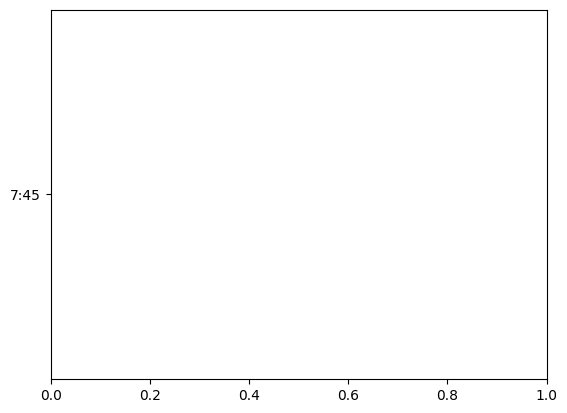

In [571]:
plt.plot(T_storages, AVG_Storages_time)
plt.xlabel("Storage Capacity")
plt.ylabel("Average Storage Waiting Time")
plt.title("Average Storage Waiting Time vs. Storage Capacity")
plt.show()

In [91]:
AVG_Stats = stats.get_average_kpis()
AVG_Stats = pd.DataFrame(AVG_Stats.items(), columns=['KPI', 'Value'])
AVG_Stats

,KPI,Value
0,avg_berth_waiting_time,4:53
1,avg_mc_waiting_time,1:06
2,avg_waiting_time,5:59
3,avg_storage_waiting_time,6:52
4,avg_Port Operation,27:06
5,avg_total_time,40:48


In [92]:
MAX_Stats = stats.get_max_kpis()
MAX_Stats = pd.DataFrame(MAX_Stats.items(), columns=['KPI', 'Value'])
MAX_Stats

,KPI,Value
0,max_berth_waiting_time,50:30
1,max_mc_waiting_time,64:30
2,max_waiting_time,64:30
3,max_Port Operation,65:58
4,max_total_time,100:18


In [93]:
ships= stats.get_ship_type_kpis()
ships_kpis_bytype = pd.DataFrame(ships)
ships_kpis_bytype


,E,D,A,B,C
avg_berth_waiting_time,5:14,4:02,5:34,0:10,4:41
avg_mc_waiting_time,1:08,0:41,0:49,0:38,1:46
avg_waiting_time,6:22,4:44,6:24,0:49,6:28
avg_Port Operation,23:07,41:24,17:31,27:04,35:35
avg_total_time,37:23,53:50,31:39,33:54,49:29
max_berth_waiting_time,50:30,47:13,43:41,2:28,48:13
max_mc_waiting_time,64:30,40:30,28:30,4:30,55:30
max_waiting_time,64:30,47:13,43:41,4:30,55:30
max_Port Operation,55:08,65:58,38:55,50:49,62:24
max_total_time,99:26,100:18,65:45,55:58,90:56


In [94]:
data = stats.ship_data
print(data)
print(len(data))
data = pd.DataFrame(data)
data.head()

[{'Arrival': datetime.datetime(2025, 1, 1, 7, 43), 'vessel_id': 'VesselE69', 'Vessel': 'E', 'Product_type': 'Solide', 'Berth_claimed': datetime.datetime(2025, 1, 1, 8, 43), 'Finished_loading': datetime.datetime(2025, 1, 2, 3, 48), 'Berth_released': datetime.datetime(2025, 1, 2, 6, 11), 'WT meteorological constraints': '0:00', 'WT Ships in queue': '0:00', 'WT Berth occupied': '0:00', 'WT Night': '1:00', 'Port Operation': '14:17', 'berth occupied': 'Solide 0', 'TAT': '22:28', 'Expected TAT': '14:17', 'Departure_Time': datetime.datetime(2025, 1, 2, 6, 11), 'cargo_loaded': 24.999999999999993}, {'Arrival': datetime.datetime(2025, 1, 2, 6, 11), 'vessel_id': 'VesselD669', 'Vessel': 'D', 'Product_type': 'Liquide', 'Berth_claimed': datetime.datetime(2025, 1, 2, 8, 11), 'Finished_loading': datetime.datetime(2025, 1, 3, 12, 45), 'Berth_released': datetime.datetime(2025, 1, 3, 16, 47), 'WT meteorological constraints': '0:00', 'WT Ships in queue': '0:00', 'WT Berth occupied': '0:00', 'WT Night': '1

,Arrival,vessel_id,Vessel,Product_type,Berth_claimed,Finished_loading,Berth_released,WT meteorological constraints,WT Ships in queue,WT Berth occupied,WT Night,Port Operation,berth occupied,TAT,Expected TAT,Departure_Time,cargo_loaded
0,2025-01-01 07:43:00,VesselE69,E,Solide,2025-01-01 08:43:00,2025-01-02 03:48:00,2025-01-02 06:11:00,0:00,0:00,0:00,1:00,14:17,Solide 0,22:28,14:17,2025-01-02 06:11:00,25.000000
1,2025-01-02 06:11:00,VesselD669,D,Liquide,2025-01-02 08:11:00,2025-01-03 12:45:00,2025-01-03 16:47:00,0:00,0:00,0:00,1:59,26:47,Liquide 0,34:36,26:47,2025-01-03 16:47:00,50.000000
2,2025-01-02 13:05:00,VesselE292,E,Solide,2025-01-02 13:05:00,2025-01-03 04:06:00,2025-01-03 20:41:00,0:00,0:00,0:00,0:00,26:03,Solide 1,31:36,25:40,2025-01-03 20:41:00,25.833333
3,2025-01-03 05:53:00,VesselE549,E,Solide,2025-01-03 08:53:00,2025-01-04 00:00:00,2025-01-04 07:33:00,0:00,0:00,0:00,3:00,18:52,Solide 0,25:40,18:30,2025-01-04 07:34:00,25.833333
4,2025-01-04 14:16:00,VesselA706,A,Solide,2025-01-04 14:16:00,2025-01-05 03:23:00,2025-01-05 13:02:00,0:00,0:00,0:00,0:00,18:33,Solide 1,22:46,18:33,2025-01-05 13:02:00,15.000000


In [95]:
print(f"loaded amount of product {data['cargo_loaded'].sum()}")
print(data[data['Product_type'] == 'Liquide']['cargo_loaded'].sum())
print(data[data['Product_type'] == 'Solide']['cargo_loaded'].sum())

loaded amount of product 15131.999999999996
7595.333333333332
7536.666666666666


In [97]:
occupation_rate = []
for c in range(Liquide_capacity):
    c_rate = (data[(data['berth occupied'] == c) & (data['Product_type'] == 'Liquide ')]['Port Operation'].apply(time_to_minutes).sum() / (60 * 24)) / 366
    occupation_rate.append(c_rate)

occupation_rate_df = pd.DataFrame({
    'Berth Occupation': range(Liquide_capacity),
    'Occupation Rate': occupation_rate
})

occupation_rate_df

,Berth Occupation,Occupation Rate
0,0,0.0
1,1,0.0


In [98]:
occupation_rate = []
for c in range(Solide_capacity):
    c_rate = (data[(data['berth occupied'] == c) & (data['Product_type'] == 'Solide')]['Port Operation'].apply(time_to_minutes).sum() / (60 * 24)) / 366
    occupation_rate.append(c_rate)


occupation_rate_df = pd.DataFrame({
    'Berth Occupation': range(Solide_capacity),
    'Occupation Rate': occupation_rate
})

occupation_rate_df

,Berth Occupation,Occupation Rate
0,0,0.0
1,1,0.0


In [99]:
np.mean(stats.storage)

76984.09669211185

In [100]:
#data.to_csv('2025_simulation.csv')
resource_queue1 = stats.queue_sizes["berth_type1"]

print(f"How many ships in the queue on average : {np.mean(resource_queue1)}")

How many ships in the queue on average : 0.2366412213740458


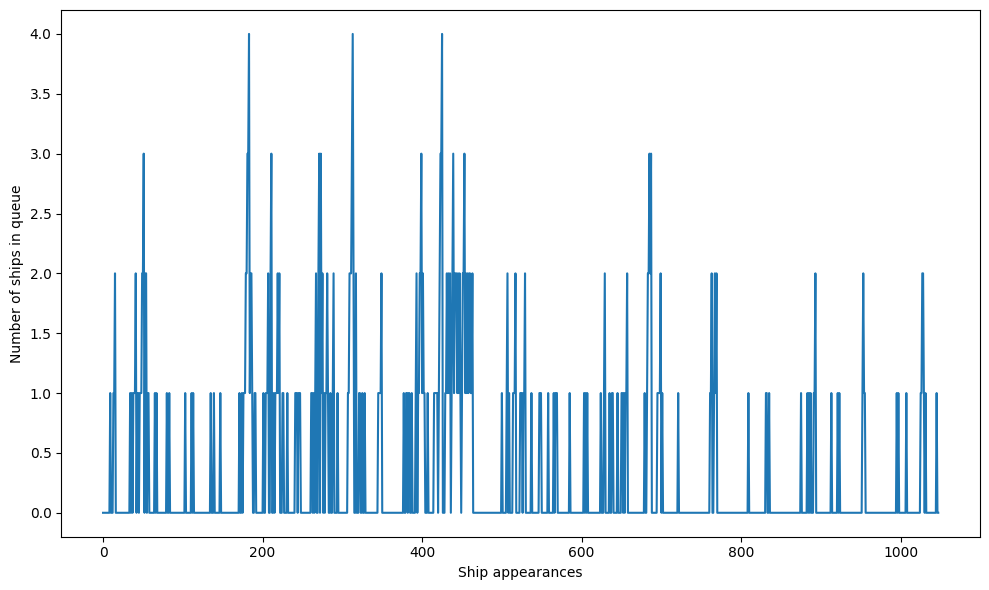

In [200]:
import matplotlib.pyplot as plt

resource_queue = stats.queue_sizes["berth"]
resource_queue1 = stats.queue_sizes["berth_type1"]
resource_queue2 = stats.queue_sizes["berth_type2"]



fig, ax = plt.subplots(1, 1, figsize=(10, 6))

plt.plot(range(len(resource_queue1)), resource_queue1)
plt.ylabel('Number of ships in queue')
plt.xlabel('Ship appearances')

plt.tight_layout()
plt.show()

In [224]:
import simpy
import numpy as np
from datetime import datetime

# Set seed for reproducibility
np.random.seed(0)

# Function to run a single simulation with given parameters
def run_simulation(capacity, P_data ,
                   mean_pre_service_time = 3 , mean_post_service_time = 3,
                   weather_data = Weather ,temporary_storage= 80_000
                   , Night_navigation = False ,simulation_time = 24 * 366):
    # Initialize the environment and resources
    env = simpy.Environment()
    berths = [simpy.Resource(env, capacity=1) for _ in range(capacity)]
    channel = simpy.PriorityResource(env, capacity=1)
    Products = ['Liquide', 'Solide']
    storage = Storage(env , temporary_storage= temporary_storage , products=Products)
    berth_maintenance = Berth(env)
    stats_0 = Stats()

    # Create the ShipArrivalModel instance


    # Create the ship generator
    start_time = datetime.strptime("00:00:00", "%H:%M:%S")
    """source = GenerateShips(env, berths, berth_maintenance, channel, weather_data, start_time,
                           mean_pre_service_time, mean_post_service_time, stats_0, production_data, storage , Night_navigation = Night_navigation)"""
    
    for product_data in P_data:
        source = GenerateShips(env, berths, berth_maintenance, channel, weather_data, start_time,
                           mean_pre_service_time, mean_post_service_time, stats_0, product_data, storage , Night_navigation = Night_navigation)
        env.process(source.generate_ships())

    # Start the ship generation process
    #env.process(source.generate_ships())

    # Run the simulation
    env.run(until=simulation_time)

    data = stats_0.ship_data
    data = pd.DataFrame(data)
    volume = data['cargo_loaded'].sum()
    occupation_rate = []

    for c in range(capacity):
        c_rate = (data[data['berth occupied'] == c]['Port Operation'].apply(time_to_minutes).sum() / (60 * 24)) / 366
        occupation_rate.append(c_rate)

    avg_ships_in_queue = np.mean(stats_0.queue_sizes["berth_type1"])
    
    system_times = stats.total_times
    system_times_min = [time_to_minutes(time) for time in system_times]
    system_times_hours = [time / 60 for time in system_times_min]
    


    waiting_times = stats.waiting_times
    waiting_times_min = [time_to_minutes(time) for time in waiting_times]
    waiting_times_hours = [time / 60 for time in waiting_times_min]
    
    

    waiting_time_bins = list(range(0, int(max(waiting_times_hours)) + 10, 10))
    total_time_bins = list(range(0, int(max(system_times_hours)) + 20, 20))

    total_time_hist, _ = np.histogram(system_times_hours, bins=total_time_bins)
    waiting_time_hist, _ = np.histogram(waiting_times_hours, bins=waiting_time_bins)


    resource_queue = stats.queue_sizes["berth"]
    queue_sizes_over_time = stats.queue_sizes["berth_type1"]

    # Collect results from stats
    simulation_results = {
        "occupation_rate": occupation_rate,
        "total_ships_by_type": stats_0.get_total_ships_by_type(),
        "forced_departures": stats_0.get_forced_departures(),
        "cargo_volume": volume,
        "average_kpis": stats_0.get_average_kpis(),
        "max_kpis": stats_0.get_max_kpis(),
        "ship_type_kpis": stats_0.get_ship_type_kpis(),
        "avg_storage": np.mean(stats_0.storage),
        "avg ships in queue": avg_ships_in_queue,
        'waiting_time_bins': waiting_time_bins[:-1],  # Exclude the last bin edge
        'waiting_time_counts': waiting_time_hist.tolist(),
        'total_time_bins': total_time_bins[:-1],
        'total_time_counts': total_time_hist.tolist(),
        'queue_sizes_over_time': queue_sizes_over_time,

    }
    return simulation_results

In [171]:
def run_simulation(capacitys , production_data , mean_pre_service_time = 3 , mean_post_service_time = 3,
                   weather_data = Weather ,temporary_storage= [80000]
                   , Night_navigation = [False] ,simulation_time = 24 * 366):

    # Create the SimPy environment
    env = simpy.Environment()
    channel = simpy.PriorityResource(env, capacity=1)  # Define the channel resource
    berth_maintenance = Berth(env)  # Initialize berth maintenance

    # Dictionaries to hold per-product resources
    sources = []
    # Create stats instance
    stats = Stats()
    product_names = []
    for d in production_data:
        product_names.extend(d.keys())

    # Remove duplicates by converting the list to a set and back to a list
    product_names = list(set(product_names))
    

    # Initialize per-product resources and processes
    for i in range(len(production_data)) :
        # Create berths for the product
        capacity = capacitys[i]
        berths = [simpy.Resource(env, capacity=1) for _ in range(capacity)]


        # Create storage instance
        storage = Storage(env, temporary_storage=temporary_storage[i])



        


        # Create GenerateShips instance
        source = GenerateShips(
            env=env,
            berths=berths,
            berth_maintenance=berth_maintenance,
            channel=channel,
            weather_data=weather_data,  # Ensure Weather is defined or imported
            start_time=start_time,
            mean_pre_service_time=mean_pre_service_time,
            mean_post_service_time=mean_post_service_time,
            stats=stats,
            production_data=production_data[i],
            storage=storage,
            Night_navigation=Night_navigation[i]
        )
        sources.append(source)

        # Start the ship generation process

        #env.process(source.generate_ships())

    # Start production processes for each product
    for source in sources:
        env.process(source.generate_ships())

    # Run the simulation
    env.run(until=simulation_time)

    data = stats.ship_data
    data = pd.DataFrame(data)
    volume = [data[data['Product_type'] == product]['cargo_loaded'].sum() for product in product_names]
    

    occupation_rate = {
    B: data[data['berth occupied'] == B]['Port Operation'].apply(time_to_minutes).sum() / (60 * 24) / 366
    for B in data['berth occupied'].unique()
    }


    avg_ships_in_queue = np.mean(stats.queue_sizes["berth_type1"])
    
    system_times = stats.total_times
    system_times_min = [time_to_minutes(time) for time in system_times]
    system_times_hours = [time / 60 for time in system_times_min]
    


    waiting_times = stats.waiting_times
    waiting_times_min = [time_to_minutes(time) for time in waiting_times]
    waiting_times_hours = [time / 60 for time in waiting_times_min]
    
    

    waiting_time_bins = list(range(0, int(max(waiting_times_hours)) + 10, 10))
    total_time_bins = list(range(0, int(max(system_times_hours)) + 20, 20))

    total_time_hist, _ = np.histogram(system_times_hours, bins=total_time_bins)
    waiting_time_hist, _ = np.histogram(waiting_times_hours, bins=waiting_time_bins)


    
    queue_sizes_over_time = stats.queue_sizes["berth_type1"]

    # Collect results from stats
    simulation_results = {
        "occupation_rate": occupation_rate,
        "total_ships_by_type": stats.get_total_ships_by_type(),
        "forced_departures": stats.get_forced_departures(),
        "cargo_volume": volume,
        "average_kpis": stats.get_average_kpis(),
        "max_kpis": stats.get_max_kpis(),
        "ship_type_kpis": stats.get_ship_type_kpis(),
        "avg_storage": np.mean(stats.storage),
        "avg ships in queue": avg_ships_in_queue,
        'waiting_time_bins': waiting_time_bins[:-1],  # Exclude the last bin edge
        'waiting_time_counts': waiting_time_hist.tolist(),
        'total_time_bins': total_time_bins[:-1],
        'total_time_counts': total_time_hist.tolist(),
        'queue_sizes_over_time': queue_sizes_over_time,

    }
    return simulation_results

In [170]:
def final_results(all_results):
    # Organize results into a structured DataFrame
    records = []

    for i, result in enumerate(all_results, 1):
        scenario_label = f"Scenario {i}"
        
        # 1. Occupation Rate
        for key, value in result['occupation_rate'].items():
            product, berth = key.split()
            kpi_name = f"Occupation Rate.{product}.{berth}"
            records.append({'KPI Name': kpi_name, f'Scenario {i} Value': value})
        
        # 2. Total Ships by Type
        for ship_type, count in result['total_ships_by_type'].items():
            kpi_name = f"Total Ships by Type.{ship_type}"
            records.append({'KPI Name': kpi_name, f'Scenario {i} Value': count})
        
        # 3. Forced Departures
        kpi_name = 'Forced Departures'
        records.append({'KPI Name': kpi_name, f'Scenario {i} Value': result['forced_departures']})
        
        # 4. Cargo Volume
        # Assuming the order of cargo_volume corresponds to products sorted alphabetically
        unique_products = sorted(set([k.split()[0] for k in result['occupation_rate'].keys()]))
        for product, volume in zip(unique_products, result['cargo_volume']):
            kpi_name = f"Cargo Volume.{product}"
            records.append({'KPI Name': kpi_name, f'Scenario {i} Value': volume})
        
        # 5. Average KPIs
        for kpi, value in result['average_kpis'].items():
            kpi_name = f"Average KPIs.{kpi}"
            records.append({'KPI Name': kpi_name, f'Scenario {i} Value': value})
        
        # 6. Max KPIs
        for kpi, value in result['max_kpis'].items():
            kpi_name = f"Max KPIs.{kpi}"
            records.append({'KPI Name': kpi_name, f'Scenario {i} Value': value})
        
        # 7. Ship Type KPIs
        for ship_type, kpis in result['ship_type_kpis'].items():
            for kpi, value in kpis.items():
                kpi_name = f"Ship Type KPIs.{ship_type}.{kpi}"
                records.append({'KPI Name': kpi_name, f'Scenario {i} Value': value})
        
        # 8. Avg Storage
        kpi_name = 'Average Storage'
        records.append({'KPI Name': kpi_name, f'Scenario {i} Value': result['avg_storage']})
        
        # 9. Avg Ships in Queue
        kpi_name = 'Average Ships in Queue'
        records.append({'KPI Name': kpi_name, f'Scenario {i} Value': result['avg ships in queue']})

    # Convert list of dictionaries to DataFrame
    df_results = pd.DataFrame(records)

    # Pivot the DataFrame to have one row per KPI Name and separate columns for each scenario's values
    df_pivot = df_results.pivot_table(index='KPI Name', 
                                    columns=[col for col in df_results.columns if col.startswith('Scenario')],
                                    values='Scenario 1 Value')

    # A better approach is to pivot on 'Scenario' labels
    # Reconstruct the DataFrame with 'Scenario' as a column

    # Reset the 'records' list to include 'Scenario' as a separate column
    records = []

    for i, result in enumerate(all_results, 1):
        scenario_label = f"Scenario {i}"
        
        # 1. Occupation Rate
        for key, value in result['occupation_rate'].items():
            product, berth = key.split()
            kpi_name = f"Occupation Rate.{product}.{berth}"
            records.append({'KPI Name': kpi_name, 'Scenario': scenario_label, 'Value': value})
        
        # 2. Total Ships by Type
        for ship_type, count in result['total_ships_by_type'].items():
            kpi_name = f"Total Ships by Type.{ship_type}"
            records.append({'KPI Name': kpi_name, 'Scenario': scenario_label, 'Value': count})
        
        # 3. Forced Departures
        kpi_name = 'Forced Departures'
        records.append({'KPI Name': kpi_name, 'Scenario': scenario_label, 'Value': result['forced_departures']})
        
        # 4. Cargo Volume
        unique_products = sorted(set([k.split()[0] for k in result['occupation_rate'].keys()]))
        for product, volume in zip(unique_products, result['cargo_volume']):
            kpi_name = f"Cargo Volume.{product}"
            records.append({'KPI Name': kpi_name, 'Scenario': scenario_label, 'Value': volume})
        
        # 5. Average KPIs
        for kpi, value in result['average_kpis'].items():
            kpi_name = f"Average KPIs.{kpi}"
            records.append({'KPI Name': kpi_name, 'Scenario': scenario_label, 'Value': value})
        
        # 6. Max KPIs
        for kpi, value in result['max_kpis'].items():
            kpi_name = f"Max KPIs.{kpi}"
            records.append({'KPI Name': kpi_name, 'Scenario': scenario_label, 'Value': value})
        
        # 7. Ship Type KPIs
        for ship_type, kpis in result['ship_type_kpis'].items():
            for kpi, value in kpis.items():
                kpi_name = f"Ship Type KPIs.{ship_type}.{kpi}"
                records.append({'KPI Name': kpi_name, 'Scenario': scenario_label, 'Value': value})
        
        # 8. Avg Storage
        kpi_name = 'Average Storage'
        records.append({'KPI Name': kpi_name, 'Scenario': scenario_label, 'Value': result['avg_storage']})
        
        # 9. Avg Ships in Queue
        kpi_name = 'Average Ships in Queue'
        records.append({'KPI Name': kpi_name, 'Scenario': scenario_label, 'Value': result['avg ships in queue']})

    # Create DataFrame
    df_all = pd.DataFrame(records)

    # Pivot to have one row per KPI Name and separate columns for each scenario's values
    df_final = df_all.pivot(index='KPI Name', columns='Scenario', values='Value').reset_index()

    # Rename columns for clarity
    df_final.columns.name = None  # Remove the hierarchy
    df_final.rename(columns={
        'Scenario 1': 'Scenario 1 Value',
        'Scenario 2': 'Scenario 2 Value'
    }, inplace=True)

    # Display the DataFrame
    return df_final

In [ ]:
np.random.seed(0)

# Define your classes here or import them if they are defined elsewhere
# from your_module import Storage, Berth, Stats, GenerateShips, Weather

# Parameters
mean_pre_service_time = 3  # Average pre-service time in minutes
mean_post_service_time = 3  # Average post-service time in minutes

simulation_time = 24 * 366  # Simulate for 366 days
start_time = datetime.strptime("00:00:00", "%H:%M:%S")

# Define fleet compositions
fleet_composition15_1 = {
    'A': {'Capacity': 15000, 'Composition': 0.3, 'Loading Rate (T/h)': 1200, 'LOA (m)': 144},
    'B': {'Capacity': 25000, 'Composition': 0.5, 'Loading Rate (T/h)': 1500, 'LOA (m)': 180},
    'C': {'Capacity': 35000, 'Composition': 0.1, 'Loading Rate (T/h)': 1800, 'LOA (m)': 196},
    'D': {'Capacity': 50000, 'Composition': 0.1, 'Loading Rate (T/h)': 2000, 'LOA (m)': 255},
    'E': {'Capacity': 80000, 'Composition': 0.0, 'Loading Rate (T/h)': 2200, 'LOA (m)': 300}
}
fleet_composition15_2 = {
    'A': {'Capacity': 15000, 'Composition': 0, 'Loading Rate (T/h)': 1200, 'LOA (m)': 144},
    'B': {'Capacity': 25000, 'Composition': 0, 'Loading Rate (T/h)': 1500, 'LOA (m)': 180},
    'C': {'Capacity': 35000, 'Composition': 0.2, 'Loading Rate (T/h)': 1800, 'LOA (m)': 196},
    'D': {'Capacity': 50000, 'Composition': 0.2, 'Loading Rate (T/h)': 2000, 'LOA (m)': 255},
    'E': {'Capacity': 80000, 'Composition': 0.6, 'Loading Rate (T/h)': 2200, 'LOA (m)': 300}
}
fleet_composition75_1 = {
    'A': {'Capacity': 15000, 'Composition': 0, 'Loading Rate (T/h)': 1200, 'LOA (m)': 144},
    'B': {'Capacity': 25000, 'Composition': 0.4, 'Loading Rate (T/h)': 1500, 'LOA (m)': 180},
    'C': {'Capacity': 35000, 'Composition': 0.5, 'Loading Rate (T/h)': 1800, 'LOA (m)': 196},
    'D': {'Capacity': 50000, 'Composition': 0.1, 'Loading Rate (T/h)': 2000, 'LOA (m)': 255},
    'E': {'Capacity': 80000, 'Composition': 0.0, 'Loading Rate (T/h)': 2200, 'LOA (m)': 300}
}
fleet_composition75_2 = {
    'A': {'Capacity': 15000, 'Composition': 0, 'Loading Rate (T/h)': 1200, 'LOA (m)': 144},
    'B': {'Capacity': 25000, 'Composition': 0, 'Loading Rate (T/h)': 1500, 'LOA (m)': 180},
    'C': {'Capacity': 35000, 'Composition': 0.0, 'Loading Rate (T/h)': 1800, 'LOA (m)': 196},
    'D': {'Capacity': 50000, 'Composition': 0.2, 'Loading Rate (T/h)': 2000, 'LOA (m)': 255},
    'E': {'Capacity': 80000, 'Composition': 0.8, 'Loading Rate (T/h)': 2200, 'LOA (m)': 300}
}
fleet_composition75_3 = {
    'A': {'Capacity': 15000, 'Composition': 0, 'Loading Rate (T/h)': 1800, 'LOA (m)': 144},
    'B': {'Capacity': 25000, 'Composition': 0.4, 'Loading Rate (T/h)': 2000, 'LOA (m)': 180},
    'C': {'Capacity': 35000, 'Composition': 0.5, 'Loading Rate (T/h)': 2800, 'LOA (m)': 196},
    'D': {'Capacity': 50000, 'Composition': 0.1, 'Loading Rate (T/h)': 4200, 'LOA (m)': 255},
    'E': {'Capacity': 80000, 'Composition': 0.0, 'Loading Rate (T/h)': 4200, 'LOA (m)': 300}
}
fleet_composition300_1 = {
    'A': {'Capacity': 15000, 'Composition': 0, 'Loading Rate (T/h)': 1800, 'LOA (m)': 144},
    'B': {'Capacity': 25000, 'Composition': 0.1, 'Loading Rate (T/h)': 2000, 'LOA (m)': 180},
    'C': {'Capacity': 35000, 'Composition': 0.5, 'Loading Rate (T/h)': 2800, 'LOA (m)': 196},
    'D': {'Capacity': 50000, 'Composition': 0.4, 'Loading Rate (T/h)': 4200, 'LOA (m)': 255},
    'E': {'Capacity': 80000, 'Composition': 0.0, 'Loading Rate (T/h)': 4200, 'LOA (m)': 300}
}

fleet_composition300_2 = {
    'A': {'Capacity': 15000, 'Composition': 0, 'Loading Rate (T/h)': 1800, 'LOA (m)': 144},
    'B': {'Capacity': 25000, 'Composition': 0, 'Loading Rate (T/h)': 2000, 'LOA (m)': 180},
    'C': {'Capacity': 35000, 'Composition': 0.0, 'Loading Rate (T/h)': 2800, 'LOA (m)': 196},
    'D': {'Capacity': 50000, 'Composition': 0.2, 'Loading Rate (T/h)': 4200, 'LOA (m)': 255},
    'E': {'Capacity': 80000, 'Composition': 0.8, 'Loading Rate (T/h)': 4200, 'LOA (m)': 300}
}
fleet_composition300_3 = {
    'A': {'Capacity': 15000, 'Composition': 0, 'Loading Rate (T/h)': 1800, 'LOA (m)': 144},
    'B': {'Capacity': 25000, 'Composition': 0.1, 'Loading Rate (T/h)': 2500, 'LOA (m)': 180},
    'C': {'Capacity': 35000, 'Composition': 0.5, 'Loading Rate (T/h)': 3300, 'LOA (m)': 196},
    'D': {'Capacity': 50000, 'Composition': 0.4, 'Loading Rate (T/h)': 4700, 'LOA (m)': 255},
    'E': {'Capacity': 80000, 'Composition': 0.0, 'Loading Rate (T/h)': 4700, 'LOA (m)': 300}
}


# Production data as a dictionary with fleet compositions
production_data75_1 = {
    'Solide': {'Composition': 1, 'Production per Year': 7_500_000, 'Fleet Composition': fleet_composition75_1}
}
production_data15_1 = {
    'Solide': {'Composition': 1, 'Production per Year': 1_500_000, 'Fleet Composition': fleet_composition15_1}
}
production_data15_2 = {
    'Solide': {'Composition': 1, 'Production per Year': 1_500_000, 'Fleet Composition': fleet_composition15_2}
}
production_data75_2 = {
    'Solide': {'Composition': 1, 'Production per Year': 7_500_000, 'Fleet Composition': fleet_composition75_2}
}
production_data75_3 = {
    'Solide': {'Composition': 1, 'Production per Year': 7_500_000, 'Fleet Composition': fleet_composition75_3}
}
production_data300_1 = {
    'Solide': {'Composition': 1, 'Production per Year': 30_000_000, 'Fleet Composition': fleet_composition300_1}
}
production_data300_2 = {
    'Solide': {'Composition': 1, 'Production per Year': 30_000_000, 'Fleet Composition': fleet_composition300_2}
}
production_data300_3 = {
    'Solide': {'Composition': 1, 'Production per Year': 30_000_000, 'Fleet Composition': fleet_composition300_3}
}

production_data = [production_data15_1 , production_data15_2 , production_data75_1 , production_data75_1, production_data75_1, production_data75_1 , production_data75_2, production_data75_3 , production_data300_1 , production_data300_1 , production_data300_1, production_data300_1  , production_data300_2 , production_data300_3]

temporary_storage = [200_000 , 100_000]
Night_navigation = [False , True]

# Run two scenarios
#results_scenario1 = run_simulation([2, 2], production_data ,temporary_storage= temporary_storage , Night_navigation= Night_navigation)
#results_scenario2 = run_simulation([2, 1], [production_data_1, production_data_2] , temporary_storage= temporary_storage , Night_navigation= Night_navigation)

# Collect all results
#all_results = [results_scenario2 ] 

In [173]:
results = run_simulation([2, 0], [production_data75_1],temporary_storage= [100_000] , Night_navigation= [False])

In [ ]:
np.random.seed(0)
temporarys = [140_000, 140_000, 375_000 , 375_000 , 375_000 , 420_000, 375_000 , 375_000 , 600_000 , 600_000 , 600_000 , 700_000 , 600_000 , 600_000]
capcitys = [1 , 1 , 2 , 3 , 2 , 2 , 2 ,2 , 5 , 6 , 5 , 5 , 5 , 5]
Night_navigation = [False , False ,
                    False , False , True, False , False , False 
                    , False , False , True , False , False , False]
all_results = [] 
for temporar, P ,capacity , night in zip(temporarys , production_data , capcitys , Night_navigation):
    results = run_simulation([capacity,0], [P],temporary_storage= [temporar] , Night_navigation= [night])
    
    all_results.append(results)

In [219]:
matrix = final_results(all_results)[['KPI Name','Scenario 1 Value' , 'Scenario 2 Value' ,'Scenario 3' , 'Scenario 4' , 'Scenario 5' , 'Scenario 6' , 'Scenario 7' , 'Scenario 8' , 'Scenario 9' , 'Scenario 10' , 'Scenario 11' , 'Scenario 12' , 'Scenario 13' , 'Scenario 14']]
Max_waiting_time = matrix[matrix['KPI Name']=='Average KPIs.avg_waiting_time']
storage_waiting_time = matrix[matrix['KPI Name']=='Average KPIs.avg_storage_waiting_time']
cargo_volume = matrix[matrix['KPI Name']=='Cargo Volume.Solide']
storage_waiting_time 

,KPI Name,Scenario 1 Value,Scenario 2 Value,Scenario 3,Scenario 4,Scenario 5,Scenario 6,Scenario 7,Scenario 8,Scenario 9,Scenario 10,Scenario 11,Scenario 12,Scenario 13,Scenario 14
3,Average KPIs.avg_storage_waiting_time,4:00,4:12,2:08,2:04,2:06,1:47,4:39,2:07,1:38,1:36,1:36,1:25,2:59,1:37


In [220]:
matrix.to_csv('Scenarios.csv')

## Average waiting time caused by temporar storage VS temporar storage capcity

C:\Users\mohammed\AppData\Local\Temp\ipykernel_18600\1335992819.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  storage_waiting_time.drop('KPI Name' , axis = 1 , inplace = True)


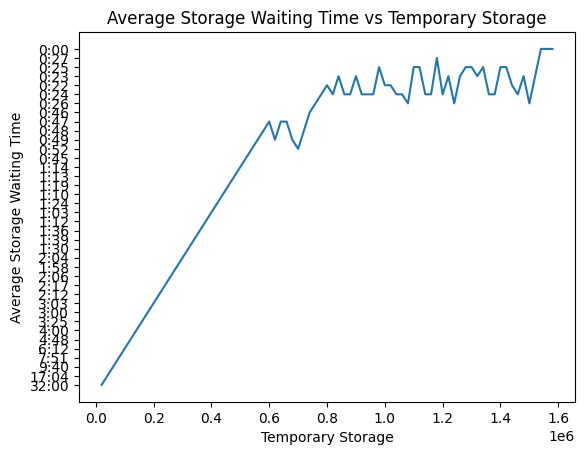

In [ ]:
temporarys = [20_000 * i for i in range(1,80)]
all_results = []
for tempo in temporarys:
    results = run_simulation([1,0], [production_data15_1],temporary_storage= [tempo] , Night_navigation= [False])
    all_results.append(results)
columns = ['Scenario '+str(i) for i in range(3,80)]
matrix = final_results(all_results)[['KPI Name','Scenario 1 Value' , 'Scenario 2 Value' ]+columns]
storage_waiting_time = matrix[matrix['KPI Name']=='Average KPIs.avg_storage_waiting_time']
storage_waiting_time.drop('KPI Name' , axis = 1 , inplace = True)
plt.plot(temporarys , storage_waiting_time.T[3])
plt.xlabel('Temporary Storage')
plt.ylabel('Average Storage Waiting Time')
plt.title('Average Storage Waiting Time vs Temporary Storage')
plt.show()

C:\Users\mohammed\AppData\Local\Temp\ipykernel_18600\3738327318.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  storage_waiting_time.drop('KPI Name' , axis = 1 , inplace = True)


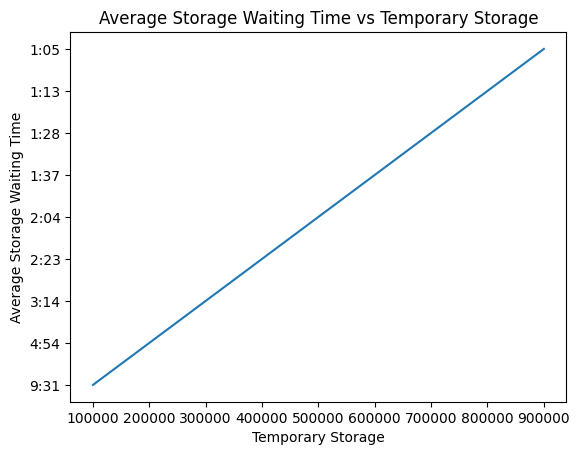

In [251]:
temporarys = [100_000 * i for i in range(1,10)]
all_results = []
for tempo in temporarys:
    results = run_simulation([6,0], [production_data300_1],temporary_storage= [tempo] , Night_navigation= [False])
    all_results.append(results)

columns = ['Scenario '+str(i) for i in range(3,10)]
matrix = final_results(all_results)[['KPI Name','Scenario 1 Value' , 'Scenario 2 Value' ]+columns]
storage_waiting_time = matrix[matrix['KPI Name']=='Average KPIs.avg_storage_waiting_time']
storage_waiting_time.drop('KPI Name' , axis = 1 , inplace = True)
plt.plot(temporarys , storage_waiting_time.T[3])
plt.xlabel('Temporary Storage')
plt.ylabel('Average Storage Waiting Time')
plt.title('Average Storage Waiting Time vs Temporary Storage')
plt.show()

## Average berth wiating time VS number of berths

C:\Users\mohammed\AppData\Local\Temp\ipykernel_18600\74008807.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  storage_waiting_time.drop('KPI Name' , axis = 1 , inplace = True)


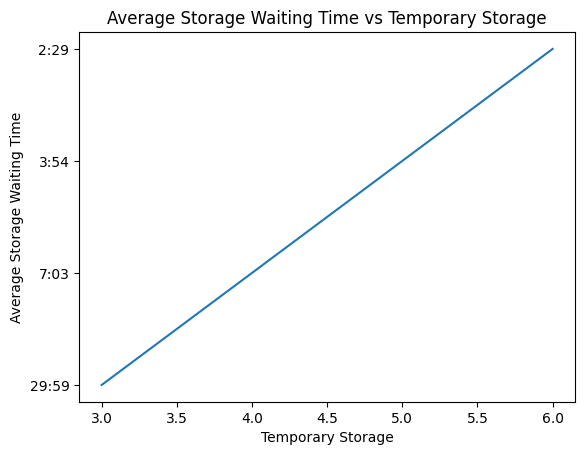

In [256]:
caps = [3, 4,  5 , 6]
all_results = []
for cap in caps:
    results = run_simulation([cap,0], [production_data300_1],temporary_storage= [300_000] , Night_navigation= [False])
    all_results.append(results)

columns = ['Scenario '+str(i) for i in range(3,5)]
matrix = final_results(all_results)[['KPI Name','Scenario 1 Value' , 'Scenario 2 Value' ]+columns]
storage_waiting_time = matrix[matrix['KPI Name']=='Average KPIs.avg_berth_waiting_time']
storage_waiting_time.drop('KPI Name' , axis = 1 , inplace = True)
plt.plot(caps , storage_waiting_time.T[1])
plt.xlabel('Temporary Storage')
plt.ylabel('Average Storage Waiting Time')
plt.title('Average Storage Waiting Time vs Temporary Storage')
plt.show()

## Night Navigation vs Max Waiting time

C:\Users\mohammed\AppData\Local\Temp\ipykernel_18600\3214243042.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  max_waiting_time.drop('KPI Name' , axis = 1 , inplace = True)


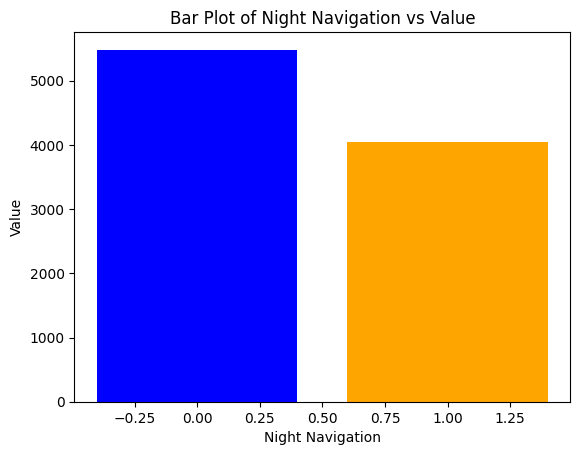

In [275]:
Night = [False , True]
all_results = []
for night in Night:
    results = run_simulation([6,0], [production_data300_1],temporary_storage= [300_000] , Night_navigation= [night])
    all_results.append(results)

columns = ['Scenario '+str(i) for i in range(3,5)]
matrix = final_results(all_results)[['KPI Name','Scenario 1 Value' , 'Scenario 2 Value' ]]
max_waiting_time = matrix[matrix['KPI Name']=='Max KPIs.max_waiting_time']
max_waiting_time.drop('KPI Name' , axis = 1 , inplace = True)
waiting = [time_to_minutes(time) for time in max_waiting_time.T[14]]

# Create the bar plot
plt.bar(Night, waiting, color=['blue', 'orange'])

# Add labels and title
plt.xlabel('Night Navigation')
plt.ylabel('Value')
plt.title('Bar Plot of Night Navigation vs Value')

# Show the plot
plt.show()

In [ ]:
from flask import Flask, render_template, request

app = Flask(__name__)

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/run_simulation', methods=['POST'])
def run_simulation_route():
    try:
        capacity = int(request.form['capacity'])
        temporary_storage = int(request.form['temporary_storage'])
        Night_navigation = 'Night_navigation' in request.form

        # Define fleet compositions and production data (using fixed values for simplicity)
        fleet_composition1 = {
            'A': {'Capacity': 15000, 'Composition': 0, 'Loading Rate (T/h)': 1200, 'LOA (m)': 144},
            'B': {'Capacity': 25000, 'Composition': 0.1, 'Loading Rate (T/h)': 1500, 'LOA (m)': 180},
            'C': {'Capacity': 35000, 'Composition': 0.5, 'Loading Rate (T/h)': 1800, 'LOA (m)': 196},
            'D': {'Capacity': 50000, 'Composition': 0.4, 'Loading Rate (T/h)': 2200, 'LOA (m)': 255},
            'E': {'Capacity': 80000, 'Composition': 0, 'Loading Rate (T/h)': 2400, 'LOA (m)': 300}
        }
        fleet_composition2 = {
            'A': {'Capacity': 15000, 'Composition': 0.4, 'Loading Rate (T/h)': 1200, 'LOA (m)': 144},
            'D': {'Capacity': 50000, 'Composition': 0.6, 'Loading Rate (T/h)': 1800, 'LOA (m)': 180}
        }
        production_data = {
            'Solide': {'Composition': 1, 'Production per Year': 7_500_000, 'Fleet Composition': fleet_composition1},
            'Liquide': {'Composition': 0, 'Production per Year': 0, 'Fleet Composition': fleet_composition2}
        }
        # Production data as a dictionary with fleet compositions
        production_data = {
            'Liquide': {'Composition': 1, 'Production per Year': 7_500_000, 'Fleet Composition': fleet_composition1}
        }

        # Production data as a dictionary with fleet compositions
        production_data1 = {
            'Solide': {'Composition': 1, 'Production per Year': 7_500_000, 'Fleet Composition': fleet_composition2}
        }

        P_data = [production_data , production_data1]
        # Run the simulation
        result = run_simulation(
            capacity=capacity,
            P_data = P_data,
            Night_navigation=Night_navigation,
            temporary_storage=temporary_storage
        )

        return render_template('result.html', result=result)
    except Exception as e:
        # Handle exceptions and display an error message
        return render_template('result.html', result={"error": str(e)})

if __name__ == '__main__':
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [29/Nov/2024 23:50:44] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [29/Nov/2024 23:50:45] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [29/Nov/2024 23:51:18] "POST /run_simulation HTTP/1.1" 200 -


In [291]:
from flask import Flask, render_template, request, redirect, url_for, flash
import pandas as pd
import simpy
from datetime import datetime

app = Flask(__name__)
app.secret_key = 'your_secret_key'  # Replace with a secure key

# Assume your existing classes are already implemented and imported
# from your_simulation_module import run_simulation, Storage, Berth, Stats, GenerateShips, Weather, Ship

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/run_simulation', methods=['POST'])
def run_simulation_route():
    try:
        # Initialize lists to hold capacities and production data for each product
        capacities = []
        production_data_list = []
        
        # Determine the number of products based on form data
        # Assuming product inputs are named as product1_name, product2_name, etc.
        product_numbers = sorted(set([key.replace('product', '').replace('_name', '') 
                                      for key in request.form.keys() 
                                      if key.startswith('product') and key.endswith('_name')]), 
                                key=lambda x: int(x))
        
        if not product_numbers:
            flash('No products found. Please add at least one product.')
            return redirect(url_for('index'))
        
        # Iterate over each product to collect form data
        Temp = []
        Nigh = []
        
        for prod_num in product_numbers:
            # Retrieve product-specific data
            product_name = request.form.get(f'product{prod_num}_name')
            composition = float(request.form.get(f'product{prod_num}_composition', 0))
            capacity = int(request.form.get(f'product{prod_num}_capacity', 0))
            temporary_storage = int(request.form.get(f'product{prod_num}_temporary_storage', 100_000))
            Temp.append(temporary_storage)
            Night_navigation = f'product{prod_num}_Night_navigation' in request.form
            Nigh.append(Night_navigation)
            
            # Initialize fleet compositions
            fleet_composition = {}
            
            # Define ship types based on product or other logic
            # Here, we use predefined fleet compositions for 'Liquide' and 'Solide'
            if product_name.lower() == 'liquide':
                fleet_composition = {
                    'A': {'Capacity': 15000, 'Composition': 0.0, 'Loading Rate (T/h)': 1200, 'LOA (m)': 144},
                    'B': {'Capacity': 25000, 'Composition': 0.1, 'Loading Rate (T/h)': 1500, 'LOA (m)': 180},
                    'C': {'Capacity': 35000, 'Composition': 0.5, 'Loading Rate (T/h)': 1800, 'LOA (m)': 196},
                    'D': {'Capacity': 50000, 'Composition': 0.4, 'Loading Rate (T/h)': 2000, 'LOA (m)': 255},
                    'E': {'Capacity': 80000, 'Composition': 0.0, 'Loading Rate (T/h)': 2200, 'LOA (m)': 300}
                }
            elif product_name.lower() == 'solide':
                fleet_composition = {
                    'A': {'Capacity': 15000, 'Composition': 0.3, 'Loading Rate (T/h)': 2000, 'LOA (m)': 144},
                    'E': {'Capacity': 25000, 'Composition': 0.7, 'Loading Rate (T/h)': 2200, 'LOA (m)': 180}
                }
            else:
                # Define other fleet compositions as needed
                fleet_composition = {}
                flash(f'Unknown product type: {product_name}. Fleet composition is empty.')
            
            # Append capacity and production data
            capacities.append(capacity)
            production_data = { product_name: {'Composition': composition, 'Production per Year': 3_000_000, 'Fleet Composition': fleet_composition}}
            
            production_data_list.append(production_data)
        
        # Run the simulation
        simulation_results = run_simulation(
            capacitys=capacities,
            production_data =production_data_list,
            weather_data = Weather,
            Night_navigation= Nigh ,  # Assuming this is handled per product
            temporary_storage=Temp  # Assuming this is handled per product
        )
        print(simulation_results)
        
        # Pass both the DataFrame and list of records to the template
        return render_template('result.html', result=simulation_results)
    
    except Exception as e:
        # Handle exceptions and display an error message
        return render_template('result.html', result=[{"error": str(e)}])
    
# Helper functions (already implemented)
def get_ship_capacity(ship_type):

    """Retrieve ship capacity based on ship type."""
    capacities = {
        'A': 15000,
        'B': 25000,
        'C': 35000,
        'D': 50000,
        'E': 80000
    }
    return capacities.get(ship_type, 0)

def get_loading_rate(ship_type):
    """Retrieve loading rate based on ship type."""
    loading_rates = {
        'A': 1200,
        'B': 1500,
        'C': 1800,
        'D': 2200,
        'E': 2400
    }
    return loading_rates.get(ship_type, 0)

def get_loa(ship_type):
    """Retrieve LOA (Length Overall) based on ship type."""
    loa_values = {
        'A': 144,
        'B': 180,
        'C': 196,
        'D': 255,
        'E': 300
    }
    return loa_values.get(ship_type, 0)

if __name__ == '__main__':
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [30/Nov/2024 20:50:56] "POST /run_simulation HTTP/1.1" 200 -


{'occupation_rate': {'Solide 1': 0.12664883120825743, 'Solide 2': 0.10923459319975713, 'Solide 0': 0.12147275349119611}, 'total_ships_by_type': {'A': 40, 'E': 96}, 'forced_departures': 0, 'cargo_volume': [3012.4999999999995], 'average_kpis': {'avg_berth_waiting_time': '0:00', 'avg_mc_waiting_time': '0:48', 'avg_waiting_time': '0:48', 'avg_storage_waiting_time': '6:21', 'avg_Port Operation': '23:04', 'avg_total_time': '31:05'}, 'max_kpis': {'max_berth_waiting_time': '0:00', 'max_mc_waiting_time': '28:30', 'max_waiting_time': '28:30', 'max_Port Operation': '49:02', 'max_total_time': '60:03'}, 'ship_type_kpis': {'A': {'avg_berth_waiting_time': '0:00', 'avg_mc_waiting_time': '1:05', 'avg_waiting_time': '1:05', 'avg_Port Operation': '17:18', 'avg_total_time': '25:03', 'max_berth_waiting_time': '0:00', 'max_mc_waiting_time': '28:30', 'max_waiting_time': '28:30', 'max_Port Operation': '44:48', 'max_total_time': '60:03'}, 'E': {'avg_berth_waiting_time': '0:00', 'avg_mc_waiting_time': '0:42', '

127.0.0.1 - - [30/Nov/2024 20:51:45] "POST /run_simulation HTTP/1.1" 200 -


{'occupation_rate': {'Liquide 1': 0.16972715543412265, 'Solide 0': 0.13629136308439588, 'Solide 1': 0.12022996357012751, 'Solide 2': 0.11985997267759563, 'Liquide 0': 0.1689947632058288}, 'total_ships_by_type': {'C': 38, 'A': 47, 'E': 92, 'D': 28, 'B': 11}, 'forced_departures': 0, 'cargo_volume': [3043.3333333333326, 3012.5], 'average_kpis': {'avg_berth_waiting_time': '0:03', 'avg_mc_waiting_time': '1:02', 'avg_waiting_time': '1:06', 'avg_storage_waiting_time': '8:46', 'avg_Port Operation': '29:04', 'avg_total_time': '38:11'}, 'max_kpis': {'max_berth_waiting_time': '7:26', 'max_mc_waiting_time': '55:30', 'max_waiting_time': '55:30', 'max_Port Operation': '75:10', 'max_total_time': '124:14'}, 'ship_type_kpis': {'C': {'avg_berth_waiting_time': '0:00', 'avg_mc_waiting_time': '2:03', 'avg_waiting_time': '2:03', 'avg_Port Operation': '34:03', 'avg_total_time': '43:31', 'max_berth_waiting_time': '0:00', 'max_mc_waiting_time': '55:30', 'max_waiting_time': '55:30', 'max_Port Operation': '62:59

In [299]:
from flask import Flask, render_template, request, redirect, url_for, flash
import pandas as pd
import simpy
from datetime import datetime

app = Flask(__name__)
app.secret_key = 'your_secret_key'  # Replace with a secure key

# Assume your existing classes are already implemented and imported
# from your_simulation_module import run_simulation, Storage, Berth, Stats, GenerateShips, Weather, Ship

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/run_simulation', methods=['POST'])
def run_simulation_route():
    try:
        # Initialize list for products
        products = []

        # Extract product numbers based on form keys
        product_numbers = sorted(
            set([
                key.replace('product', '').replace('_name', '') 
                for key in request.form.keys() 
                if key.startswith('product') and key.endswith('_name')
            ]), 
            key=lambda x: int(x)
        )

        if not product_numbers:
            flash('No products found. Please add at least one product.')
            return redirect(url_for('index'))

        # Define fixed ship types
        fixed_ship_types = ['A', 'B', 'C', 'D', 'E']

        for prod_num in product_numbers:
            # Retrieve product-specific data
            product_name = request.form.get(f'product{prod_num}_name')
            composition = float(request.form.get(f'product{prod_num}_composition', 0))
            capacity = int(request.form.get(f'product{prod_num}_capacity', 0))
            temporary_storage = int(request.form.get(f'product{prod_num}_temporary_storage', 100_000))
            production_per_year = int(request.form.get(f'product{prod_num}_production_per_year', 0))
            night_navigation = f'product{prod_num}_Night_navigation' in request.form

            # Initialize fleet compositions
            fleet_composition = {}

            for ship_type in fixed_ship_types:
                # Construct form field names for each ship attribute
                ship_capacity_field = f'product{prod_num}_ship{ship_type}_capacity'
                ship_composition_field = f'product{prod_num}_ship{ship_type}_composition'
                ship_loading_rate_field = f'product{prod_num}_ship{ship_type}_loading_rate'
                ship_loa_field = f'product{prod_num}_ship{ship_type}_loa'

                # Retrieve ship-specific data entered by user
                try:
                    ship_capacity = int(request.form.get(ship_capacity_field, 0))
                    ship_composition = float(request.form.get(ship_composition_field, 0))
                    ship_loading_rate = int(request.form.get(ship_loading_rate_field, 0))
                    ship_loa = int(request.form.get(ship_loa_field, 0))
                except ValueError:
                    flash(f'Invalid input for ship {ship_type} in product {prod_num}. Please enter valid numbers.')
                    return redirect(url_for('index'))

                # Validate ship type if necessary
                if ship_type not in fixed_ship_types:
                    flash(f'Unknown ship type: {ship_type}.')
                    return redirect(url_for('index'))

                # Assign ship attributes to fleet composition
                fleet_composition[ship_type] = {
                    'Capacity': ship_capacity,
                    'Composition': ship_composition,
                    'Loading Rate (T/h)': ship_loading_rate,
                    'LOA (m)': ship_loa
                }

            # Append product data with fleet composition
            product_data = {
                'name': product_name,
                'composition': composition,
                'capacity': capacity,
                'temporary_storage': temporary_storage,
                'production_per_year': production_per_year,
                'night_navigation': night_navigation,
                'fleet_composition': fleet_composition
            }

            products.append(product_data)

        # Run the simulation with the collected products and their ships
        simulation_results = run_simulation(
            products=products,
            weather_data=Weather(),  # Ensure Weather is correctly instantiated
            # Add other necessary parameters as required by your run_simulation function
        )

        print(simulation_results)  # For debugging purposes

        # Pass the simulation results to the 'result.html' template
        return render_template('result.html', result=simulation_results)

    except Exception as e:
        # Handle exceptions by flashing an error message and redirecting to the index
        flash(f'An error occurred: {str(e)}')
        return redirect(url_for('index'))

# Helper functions (already implemented)
def get_ship_capacity(ship_type):
    """Retrieve ship capacity based on ship type."""
    capacities = {
        'A': 15000,
        'B': 25000,
        'C': 35000,
        'D': 50000,
        'E': 80000
    }
    return capacities.get(ship_type, 0)

def get_loading_rate(ship_type):
    """Retrieve loading rate based on ship type."""
    loading_rates = {
        'A': 1200,
        'B': 1500,
        'C': 1800,
        'D': 2200,
        'E': 2400
    }
    return loading_rates.get(ship_type, 0)

def get_loa(ship_type):
    """Retrieve LOA (Length Overall) based on ship type."""
    loa_values = {
        'A': 144,
        'B': 180,
        'C': 196,
        'D': 255,
        'E': 300
    }
    return loa_values.get(ship_type, 0)

if __name__ == '__main__':
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [30/Nov/2024 21:55:54] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [30/Nov/2024 21:56:35] "POST /run_simulation HTTP/1.1" 302 -
127.0.0.1 - - [30/Nov/2024 21:56:35] "GET / HTTP/1.1" 200 -
